# Исследование корреляций на форексе

Построение матрицы корреляций всех валютных пар и попытка составить минревертные баскеты.

In [3]:
# Все импорты и конфиги здесь
%pylab inline
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
pd.options.display.max_columns = None

import os,sys
import statsmodels.tsa.stattools as ts
from scipy.stats import linregress
from datetime import datetime as dt
import seaborn as sns
sns.set(style="darkgrid",  palette="muted", rc={'figure.figsize':(16,5)})

from hurst import hurst
from data_importer import import_data

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Загрузка данных Финама

In [5]:
tickers = open('data/tickers.txt').read().strip().split('\n')
corr_mat = pd.DataFrame(index=tickers, columns=tickers)

[autoreload of data_importer failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.4/dist-packages/ipython-3.1.0-py3.4.egg/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named 'finam_codes'
]


In [15]:
t_map = {}
FREQ = '5m'
N_TRIES = 3
FROM = dt(2016,6,1).date()
TO = dt(2016,7,1).date()
BASEDIR = "data/%s_%s/%s" % (FROM,TO,FREQ)

In [ ]:
# Подгрузим если надо
if not os.path.exists(BASEDIR):
    import_data(FROM, TO, FREQ, BASEDIR, N_TRIES)

In [8]:
for t in tickers:
    t = t.strip()
    df = pd.read_pickle('%s/%s.pickle' % (BASEDIR,t))
    # отбросим дубликаты
    t_map[t] = df.groupby(df.index).first()
# Создаем панельку с данными
bars = pd.Panel(data=t_map)
bars.dropna(inplace=True, axis=1)

## Матрица корреляций

In [17]:
# Период для тестирования
# Нужно посмотрреть на разных периодах!!!
start = '1-2016'; end = '7-2016'
data=bars.ix[:,start:end,'close'].diff().corr()

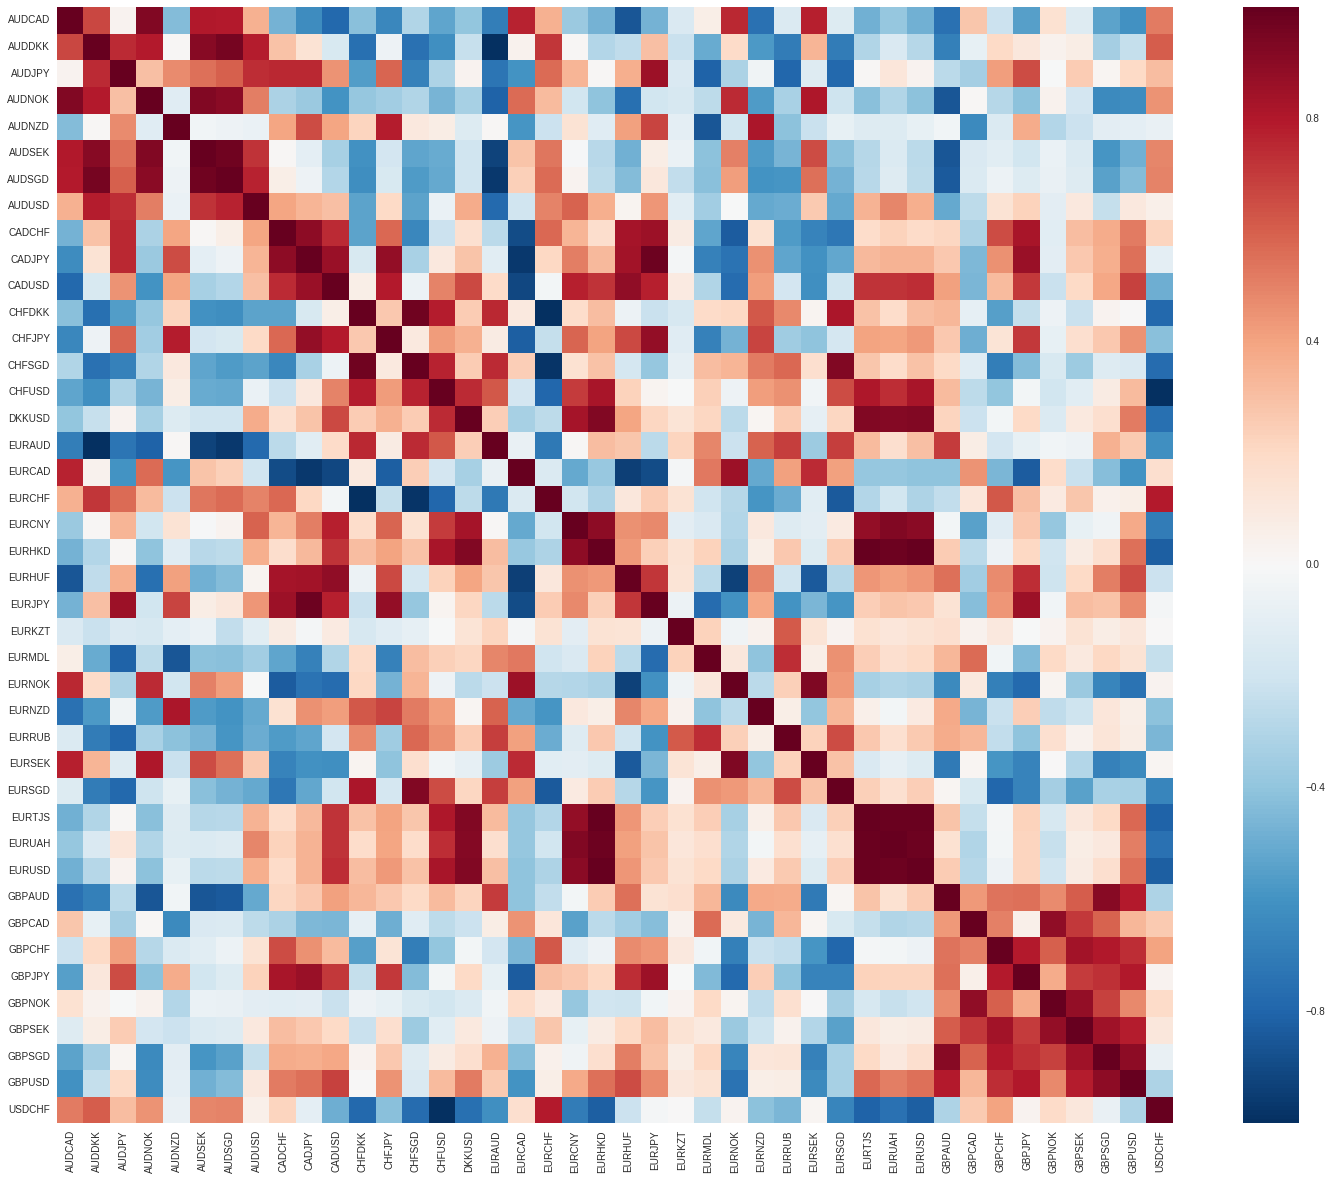

In [14]:
with plt.rc_context(rc={'figure.figsize':(25,20)}):
    sns.heatmap(data, annot=False)

Далее я хочу померить возврат к среднему самих рядов.
Причем это надо как-то компактно и автоматизированно сделать!

## Стационарность валютных пар

'y = 0.148776 x + -161.860270'

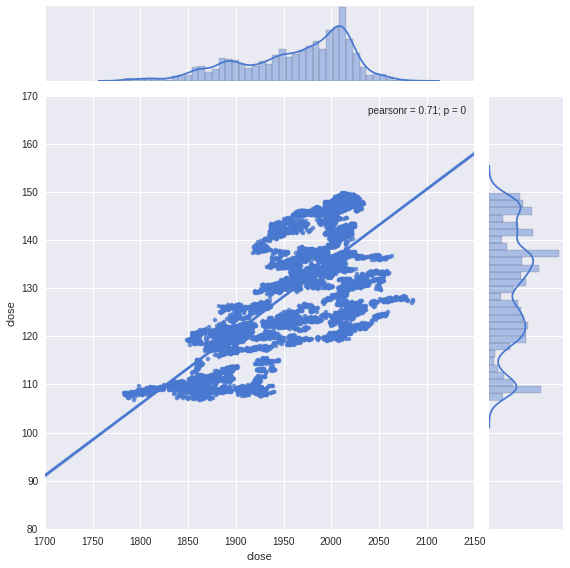

In [94]:
index = lkoh.index.intersection(gazp.index)
lkoh = lkoh[index]; gazp = gazp[index]
x1 = lkoh[:len(lkoh)/2]; y1=gazp[:len(gazp)/2]
x2 = lkoh[len(lkoh)/2:]; y2=gazp[len(gazp)/2:]
beta,intercept,r,p,stderr = linregress(x1, y1)
sns.jointplot(x1, y1, kind='reg', size=8)
"y = %f x + %f" % (beta,intercept)

In [95]:
residuals = y2 - beta * x2 - intercept
(residuals.mean(),residuals.std())

(1.1140399770753038, 4.7728273911222967)

0.21070321470004647

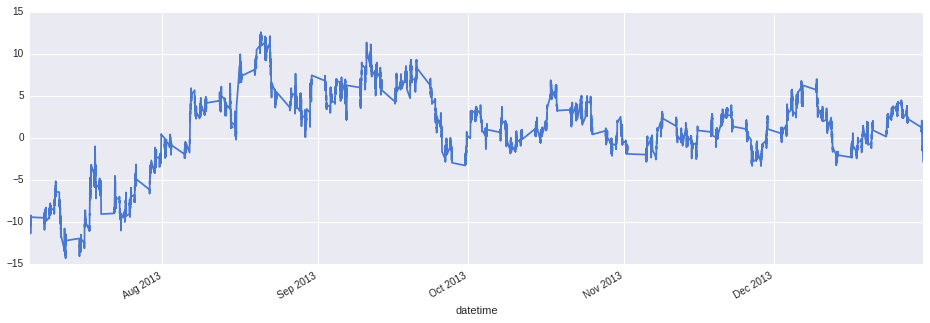

In [96]:
residuals.plot()
hurst(log(abs(residuals)))

In [97]:
# Don't believe? Check me, verificate!
(hurst(log(y2)), hurst(log(x2)))

(0.49974859477551892, 0.45820093942447271)

#### Augmented Dickey-Fuller test

Тест стационарности ряда.

In [98]:
adf_res,_,crits,reg_res = ts.adfuller(residuals, maxlag=10, regresults=True)
(adf_res, crits)

(-3.2763555111798035,
 {'1%': -3.430850503900897,
  '10%': -2.5668877391301312,
  '5%': -2.8617611986709535})

Результат лежит за 5% ⇒ Вероятность нестационарности ряда < 5%

In [74]:
# DF regression summary
reg_res.resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     34.12
Date:                Thu, 11 Feb 2016   Prob (F-statistic):           1.66e-15
Time:                        00:24:41   Log-Likelihood:                 3865.2
No. Observations:               13108   AIC:                            -7724.
Df Residuals:                   13105   BIC:                            -7702.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0014      0.000     -2.969      0.003        -0.002    -0.000
x2            -0.0664      0.009     -7.624      0.000        -0.084    -0.049
const         -0.0053      0.002     -2.329      0.020        -0.010    -0.001
==============================================================================
Omnibus:                     6551.630   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           881830.202
Skew:                          -1.386   Prob(JB):                         0.00
Kurtosis:                      43.086   Cond. No.                         26.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

![alt text](http://www.weepop.net/wp-content/uploads/2015/02/thatsall.jpg "That's all, folks!")